# **The Grover Search**
***

In this lab session, we will cover the Grover Algorithm. Like the previous algorithms we’ve studied, at the heart of
the Grover Algorithm is a Hadamard Transformation. However, this algorithm does not solve a ’blackbox’ problem, making it
different from our previous lab lessons. Instead, we will be solving a searching problem, whereby we would like to locate one
particular state with a measurement, out of $2^N$ .

In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute 
from qiskit.visualization import plot_histogram

import math as m 

S_simulator = Aer.backends(name='statevector_simulator')[0]

M_simulator = Aer.backends(name='qasm_simulator')[0]

In [2]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [3]:
'''
Do not worry about the length of this code block.
You dont need to understand this code.
It is only to help you view the wavefunction in a better way
'''
import numpy as np
import scipy as sci

def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(statevec),2))
  for i in np.arange( int(len(statevec)) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)


In [5]:
'''
Do not worry about the length of this code block.
We have implemented this only to keep things more concrete than abstract.
It is a generic implementation of the above defined 
strategy for any number of control NOTs in the contol gate 
be it power of 2 or not and odd number as well.
Just remember the above the stategy and we are good to go
'''

def n_NOT(qc, control, target, anc):
  '''
  performs an n-NOT gate
  '''
  n = len(control) 
  instructions = []
  active_ancilla = [] 
  q_unused = []
  q = 0
  a = 0

  while ((n > 0) or (len(q_unused)!=0) or (len(active_ancilla)!=0)):
    if( n > 0):
      if((n-2) >= 0):
        instructions.append( [control[q], control[q+1], anc[a]] ) 
        active_ancilla.append(a)
        a = a + 1
        q = q + 2
        n = n - 2
      if( (n-2) == -1):
        q_unused.append( q ) 
        n = n - 1
      
    elif(len(q_unused) != 0 ): 
      if(len(active_ancilla)!=1):
        instructions.append( [control[q], anc[active_ancilla[0]], anc[a]]) 
        del active_ancilla[0]
        del q_unused[0] 
        active_ancilla.append(a)
        a = a + 1
      else:
        instructions.append( [control[q], anc[active_ancilla[0]], target] ) 
        del active_ancilla[0] 
        del q_unused[0]
    
    elif(len(active_ancilla) !=0): 
      if( len(active_ancilla) > 2 ):
        instructions.append( [anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] ) 
        active_ancilla.append(a)
        del active_ancilla[0] 
        del active_ancilla[0]
        a = a + 1
      elif (len(active_ancilla)==2):
        instructions.append([anc[active_ancilla[0]], anc[active_ancilla[1]], target]) 
        del active_ancilla[0]
        del active_ancilla[0]

  for i in np.arange(len(instructions) ):
    qc.ccx (instructions[i][0], instructions[i][1], instructions[i][2] )

  del instructions[-1]
  for i in np.arange(len(instructions) ):
    qc.ccx( instructions[0-(i+1)][0], instructions[0 -(i+1)][1], instructions[0-(i+1)][2] )

## **The Grover Algorithm**
***

The Grover Algorithm, also referred to as a Grover Search, is a quantum algorithm that can be thought of as searching through
an unordered list. Imagine you want to look someone up in a directory, which is alphabetically ordered by last name, but you
only have their first name. In this scenario, you are stuck going through each entry one at a time, until you eventually happen
upon the person you are looking for.

Exhaustively searching through the database represents the classical approach, which requires on average $\frac{N}{2}$ evaluations, which
is of the order $O(N)$. By instead using the Grover Algorithm, we can complete this search (with a high success probability)
using only $O(\sqrt{N})$ evaluations.

✅ Fun Fact : Dr Lov Grover is a [distinguished alumni of IIT Delhi](https://alumni.iitd.ac.in/home/index.php/2021/10/21/dr-lov-k-grover/). He received his BTech in Electrical Engineering from IIT Delhi in 1981.

## **Setting Up the Problem**
***

Our goal is to create a quantum algorithm that will allow us to pick any state we want (within the $2^N$ space), and then attempt
to find that state with a single measurement. As we shall see, we will measure our desired state, which we shall refer to as our
’marked state’, with a high success probability. In addition, larger systems will result in higher success probabilities, a nice
feature that is unique to the quantum approach!

Like the classical search, our quantum algorithm needs to first reflect the problem of having no a priori knowledge of where the
marked entry is located. For our quantum algorithm, we can represent this by starting our system in an equal superposition of
all states. Thus, the starting point for our code will be to specify the size of our problem, and then create an equal superposition:

In [7]:
N = 3

q  = QuantumRegister(N, name = "q")
qc = QuantumCircuit(q, name = "qc")

for i in np.arange(N):
  qc.h(q[int(i)])

Wavefunction(qc) 

0.35355 |000>     0.35355 |100>     0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


In the code above, we specify the size of our problem with the parameter N , creating a quantum system of the size 2N . N is
the number of qubits we will be using, which means we can create significantly large systems with only a minimal amount of qubits. We prepare our system in an equal superposition of all $2^N$ states by applying a Hadamard gate to each qubit, creating the
following initial state

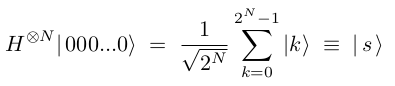

Now, let’s do some simulated measurements on this state. These measurements represent the classical approach of picking
blindly until we happen on our desired state:

In [27]:
N = 3

q  = QuantumRegister(N, name = 'q')
c = ClassicalRegister(N, name = 'c')
qc = QuantumCircuit(q,c, name = 'qc')

for i in range(N):
	qc.h(q[i])
qc.measure(q,c)
job = execute(qc,M_simulator,shots=100)
result = job.result()
result.get_counts(qc)

{'010': 10,
 '001': 7,
 '101': 21,
 '110': 16,
 '100': 11,
 '000': 8,
 '011': 14,
 '111': 13}

Take a look at the measurement counts for each state and verify that all states in the system are equally probable (although
it’s rare to get a perfectly even distribution). Using a quantum system like this to find a specific state is quite slow, and in
fact it’s even worse than the classical analog! Consider what the typical method would be if we were to pick states at random
classically: suppose we are looking for the state |000⟩, but instead got |110⟩. It would be crazy to put |110⟩ back into the mix
and try again. Thus, we would naturally remove is from the problem, thereby improving our odds of finding |000⟩ on the next try.


The main advantage to a classical search is the ability to ’remember’ past measurements, and remove them from the problem.
By doing so, the classical approach will slowly narrow down the pool of possible entries, until eventually finding the desired
one. When using a quantum approach, we can’t do this. If we measure the state |110⟩, that’s it. Our wavefunction collapses to
that state, and we’ve failed our search. And, when we go to prepare the system the next time, we have no way of removing the
state |110⟩ from the system, which means we could get it again!


The difference between the classical and quantum approaches to a search problem are very noteworthy. Since our quantum
system has no memory of past measurements, we can only hope to find our desired state with a single attempt. Thus, the goal of
the Grover Algorithm will be to boost our chance of measuring the desired state.

## **Implementing an Oracle**
***

Now that we have our equal superposition of $2^N$ states, we can begin to construct our Grover Algorithm.

To do this, the first thing we need is an operator $U_w$ , known as an ’oracle.’ Simply put, this is an operator that picks out a single
state in the system, say |0101⟩, and applies an operation. Specifically, this oracle operator $U_w$ isolates a single state such that it
is the only state in the system that will then receive the desired operation.

We’ve worked with similar operators in the past, such as the higher order n_NOT gates in previous lab sessions. In essence, that’s exactly what we’re going to do here as well. By default, control gates only pick out states where all
of the control qubits are in the state |1⟩, for example:

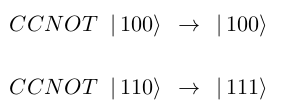

For our Grover algorithm, we need our oracle to be able to pick out any state, including states with 0’s on any qubit. Luckily,
we’ve already seen how to pull off this trick before in our past blackbox functions.

In order to make sure that only our marked state is the control-state, we will perform a series of X gates to transform our marked
state to the state of all 1’s: |111...1⟩. Simultaneously, this transformation will also guarantee that our marked state is the only
state in the system of all 1’s. Thus, when we apply our N-qubit control gate operation, its effect will only get applied to our
marked state. Then, we will transform all of the states back to the original basis, using the same X gates:

In [28]:
def X_Transformation (qc, qreg, state):
  '''
  Input:qc (QuantumCircuit), qreg (QuantumRegister), state (array)
  Applies the neccessary X gates to transform 'state' to the state of all 1's
  '''
  for j in np.arange(len(state)):
    if(int(state[j])==0): 
      qc.x( qreg[int(j)])

In [29]:
q = QuantumRegister(2, name = 'q') 
G_qc = QuantumCircuit (q, name = 'qc')

G_qc.h( q[0])
G_qc.h( q[1])
G_qc.cz( q[0],q[1] )

print(" Initial State ")
Wavefunction(G_qc)

print("\n X_Transformation: [00> <-> [11>")
X_Transformation (G_qc, q, [0,0]) 

print("\n After X(0) + X(1) ")
Wavefunction(G_qc)

 Initial State 
0.5 |00>     0.5 |10>     0.5 |01>     -0.5 |11>     

 X_Transformation: [00> <-> [11>

 After X(0) + X(1) 
-0.5 |00>     0.5 |10>     0.5 |01>     0.5 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


In the example above, we transform the state |00⟩ → |11⟩ by applying X gates on qubits 0 and 1. We mark the |11⟩ state with a
negative phase just for clarity here, so we can track which state it gets transformed to (the state that ends up with the negative
sign is the original state that maps to |11⟩ ).

In this example, we use function X_Transformation defined above to perform the correct X gates, specifying the desired state we
want to map to the state of all 1’s. In general, choosing which X gates to perform is very straightforward, as all we need to do it
look at where the 0’s are for our marked state. In the example above, our marked state would be |00⟩, which has 0’s in the qubit
locations 0 and 1, therefore we applied the gates X(0) and X(1).

Equally as important as the transformation of the marked state, is the effect of this transformation on the rest of the system. For
example, consider the effect of the X Transformation when |001⟩ is the marked state:

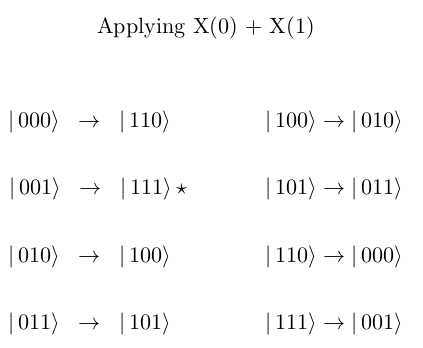

No other state in the system gets mapped to |111⟩, exactly the result we need. If we consider that our marked state is ’unique’,
in that no other state in the system has the same 0’s and 1’s, it makes sense that the transformation to |111⟩ is unique as well,
mapping all other states elsewhere.

The last step is the transformation back to our original basis. For our Grover Algorithm, transforming our marked state to |11...1⟩
will allow us to apply a higher order control operation, but afterwards, we must transform back in order to search for the marked
state in its original form. Lucky for us, the transformation back to our original basis is just as easy. All we need to do is apply
the exact same X gates again:

In [31]:
q = QuantumRegister(2, name = 'q') 
G_qc = QuantumCircuit (q, name = 'qc')
marked = [0,1]

G_qc.h( q[0])
G_qc.h( q[1])
G_qc.cz( q[0],q[1] )
G_qc.x( q[0])

print(" Initial State ")
Wavefunction(G_qc)

X_Transformation(G_qc, q, marked) 

print("\n ____ X(0)___ ")
Wavefunction(G_qc)

X_Transformation (G_qc, q, marked) 
print("\n ____ X(0)___ ")

Wavefunction(G_qc)

 Initial State 
0.5 |00>     0.5 |10>     -0.5 |01>     0.5 |11>     

 ____ X(0)___ 
0.5 |00>     0.5 |10>     0.5 |01>     -0.5 |11>     

 ____ X(0)___ 
0.5 |00>     0.5 |10>     -0.5 |01>     0.5 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


In the example above, we successfully transform back and forth between our marked state and |11...1⟩. Next, we are going to
use this transformation to effectively apply a higher order control-Z gate to our marked state.

## **Sign Flip on |111...1⟩ (The Oracle Function)**
***

The first component to our Grover Algorithm, the oracle $U_w$ , will achieve the effect of an N-control-Z gate, applied to our
marked state. That is to say, it will achieve the effect: |11...1⟩ → −|11...1⟩. In matrix form, this operator looks like:

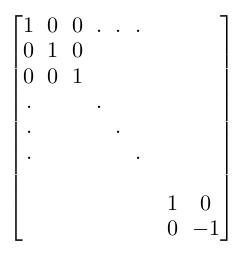

There are a couple ways to achieve this operation, but we are going to use the most common method, which involves an ancilla
qubit in the state |−x⟩. In fact, we’ve already seen this trick in Deutsch-Jozsa and Berstein-Vazirani Algorithms.

Essentially, we will be taking advantage of the effect of an X gate on the state | − x⟩:

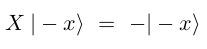

Since every state in the system will be coupled to this |−x⟩ state, we must be sure that only our marked state receives the X gate
operation on the ancilla qubit. For example, suppose |01⟩ was our marked state:

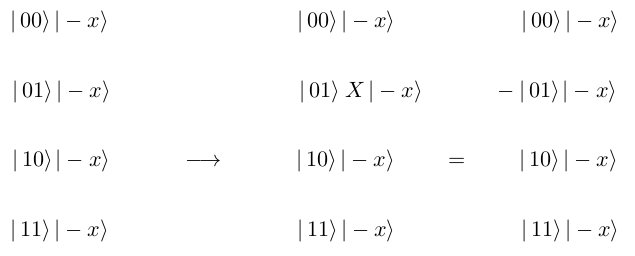

This example above shows the desired effect of our Oracle, essentially causing our marked state to pick up a negative phase.
Then, after the negative sign has been applied, we work with our main system only, completing ignoring the ancilla.

To achieve the effect shown above, we will need the combination of our X_Transformation function with n_NOT, also one of
our earlier implemented functions. In short, the n_NOT function is equivalent to any higher order CNOT gate of our choosing. Thus, we
will use it to perform an N th order CNOT operation (N being the number of qubits in our system), with the target qubit being
the ancilla.

In total, the flow of our Oracle function will be as follows:

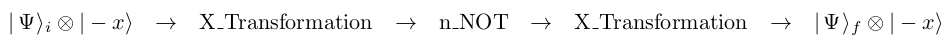

To avoid clutter, we combine all of the operation steps above into a function called **Grover_Oracle**:

In [32]:
def Grover_Oracle(mark, qc, q, an1, an2):
  '''
  Input:
  mark (array),qc (QuantumCircuit),q (QuantumRegister) an1 (QuantumRegister)an2 (QuantumRegister)
  Appends the neccessary gates for a phase flip on the marked state
  i.e. picks out the marked state and applies a negative phase
  '''
  qc.h( an1[0] )
  X_Transformation(qc, q, mark)
  if( len(mark) > 2 ):
    n_NOT( qc, q, an1[0], an2 )
  if( len(mark) == 2 ):
    qc.ccx( q[0], q[1], an1[0] )
  X_Transformation(qc, q, mark)
  qc.h( an1[0] )

Note that in these steps, the Hadamard gates on the ancilla
qubit are separated out to better show the negative sign being applied to the marked state.

In [34]:
q  = QuantumRegister(3, name='q')
anc =  QuantumRegister(1, name='anc') 
n_anc =  QuantumRegister(1, name='nanc')
G_qc  = QuantumCircuit(q, anc,n_anc, name='qc')

marked =  [0,1,0]

G_qc.h( q[0])
G_qc.h( q[1])
G_qc.h( q[2])
G_qc.x( anc[0])

print(" ____  Initial State ___ ") 
Wavefunction(G_qc, systems = [3,1,1], show_systems=[True, False, False] )
print(' ')

Grover_Oracle (marked, G_qc, q, anc, n_anc)

print(" \n ___ Final State ____ ")

Wavefunction(G_qc, systems = [3,1,1], show_systems=[True, False, False] )

 ____  Initial State ___ 
0.35355 |000>     0.35355 |100>     0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     
 
 
 ___ Final State ____ 
0.35355 |000>     0.35355 |100>     -0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


The example above follows all of the steps for our Oracle operator. Feel free to change the array ’marked’
in this example, and see that it will always pick out the correct state. Also note that calling upon the n_NOT function requires
the use N − 2 extra qubits, which we’ve chosen not to display in our wavefunctions.

Grover Oracle takes care of all the instructions for us, so long as we prepare the system in the
correct initial state:

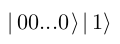

With the Oracle operator $U_w$ now in hand, we’re ready to move on to the second part of Grover’s Algorithm, which will require
us to revisit the Hadamard transformation one final time.

## **Reflection About the Average**
***

Like Simon’s Algorithm from our lectures, Grover’s Algorithm will require multiple runs of our quantum system. The difference
here, is that we will not be making measurements after each run. Instead, we will perform multiple ’Grover Iterations’, followed
by a single measurement at the very end.

In one sentence, we can say that mathematically: ”One Grover Iteration is equivalent to a reflection about the average amplitude.”
(Don’t worry, we will make sense of this.) Let’s start by talking about a reflection. Geometrically, a reflection involves two
components: the object who is being reflected, and the point, line, plane, etc. with which we reflect about. For example,
consider the diagram below, which illustrates a reflection of state |ψ⟩ about the state |0⟩:

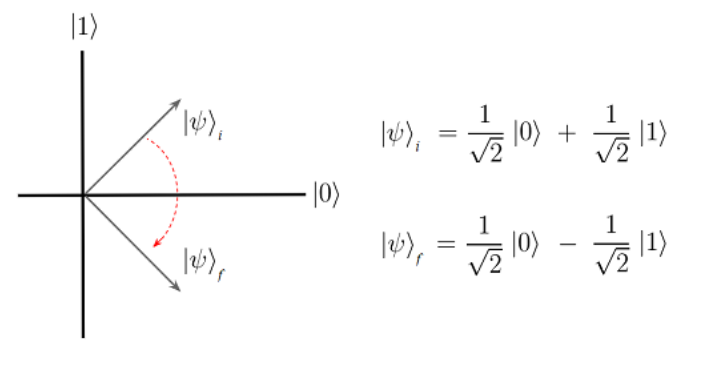

In this example, the object being reflected is the state |ψ⟩, and the point of reflection is the state |0⟩. We can see that a ’reflection about |0⟩’ is equivalent to a sign flip on the |1⟩ state. And in general, a reflection about a single state |φ⟩ leaves a quantum state’s |φ⟩ component unchanged, while flipping the sign on all other components:

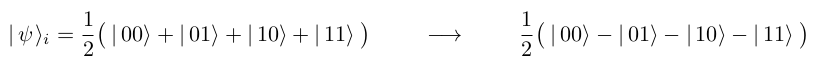

However, Grover’s Algorithm will require use to perform reflections about a state for arbitrarily large systems, which translates
to implementing many of these sign flips. Needless to say, sign flipping every single state besides just one is a bit tedious, and
quite costly in terms of gates. Luckily for us, we can achieve the same net effect by taking the reverse route: only flipping the
sign on the single state. Consider our first example again, only this time we will flip the sign on the |0⟩ component:

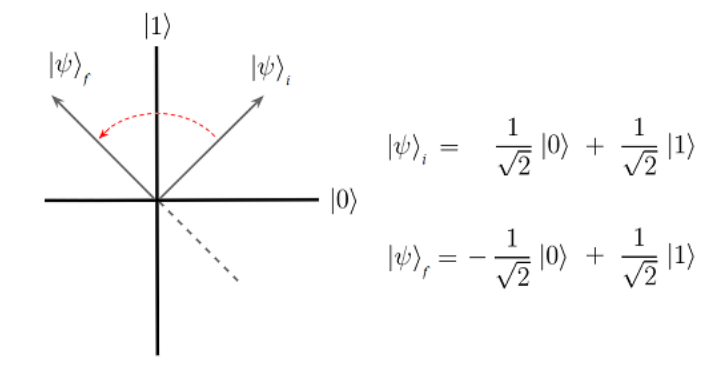

In the diagram above, notice how both final states ’align’, shown by the dashed line marking where $|ψ⟩_f$ from the first example
was. Denoting the final states from the two examples as $|ψ⟩_{1f}$ and $|ψ⟩_{2f}$ , we have that $|ψ⟩_{1f}$ = − $|ψ⟩_{2f}$ . Or more specifically,
the two states are parallel, with opposite phase.

The nice thing about this for us, is that a measurement on the system can’t tell the difference between $|ψ⟩_{1f}$ and $|ψ⟩_{2f}$ . Thus, so
long as the opposite phase isn’t an issue anywhere else in our algorithm, we are free to use either reflection method as we see
fit. And for our Grover Algorithm, we are definitely going to use the second method in order to minimize steps.

Now, let’s discuss what it means to ’reflect about the average amplitude’. Perhaps the easiest way to understand this initially, is
with a diagram:

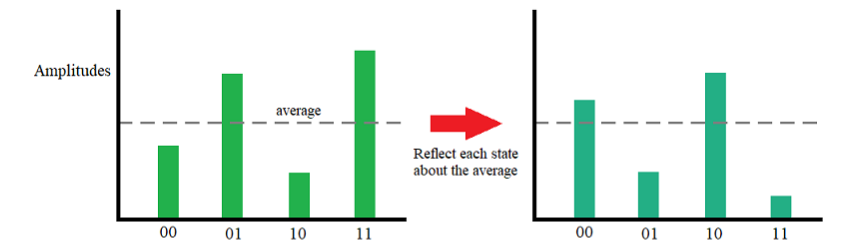

This diagram illustrates the effect we are going for: we take the average of all the states’ amplitudes, and reflect each state’s
individual amplitudes about that average. We can see that states with amplitudes above the average get reflected below it, and
vice versa. In total, the average amplitude for the system is unchanged, even though all of the states have. Mathematically, this
is then a unitary operation:

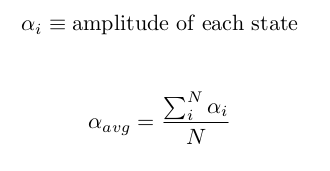

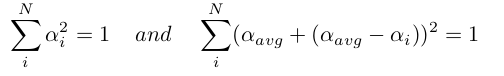

We won’t go through this proof here, but rather provide a simple arithmetic example (which is by no means a proof):

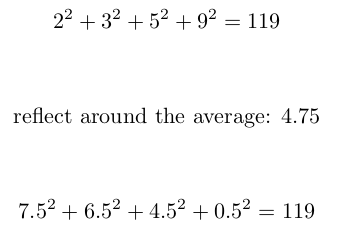

## **$U_s$ - Grover Diffusion Operator**
***

The operator that is going to achieve this reflection about the average will be $U_s$ , often referred to as the Grover Diffusion
Operator. We will start by writing out the effect of the operation we want:

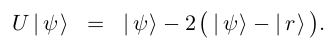

where |ψ⟩ is the state of our system, and |r⟩ represents an equal superposition of all states, where each state has an amplitude of
$α_{avg}$ :

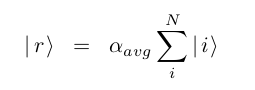

This state |r⟩ is most definitely not normalized, meaning we can’t physically create it, but represents what we want to happen as
a result from our operation. Specifically, the operation | ψ⟩ − 2( | ψ⟩ − | r⟩) is written this way in order to understand its two
components:

1. take the difference in amplitudes between each state and the average: ( | ψ⟩ − | r⟩ )
2. double each of these differences, and subtract them from the initial amplitudes: | ψ⟩ − 2( · · ·) .

For example, suppose we have a system where the amplitude for the state |01⟩ is $α_{01}$ = 0.7, and the average amplitude for the
whole system is $α_{avg}$ = 0.45. We want the effect of our operation to do the following:

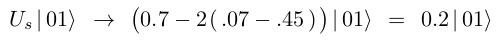

Hopefully this example illustrates what we are going for. We want an operation that uses the difference between each state and
the average ( $α_i − α_{avg}$ ), and subtracts double this amount from the initial amplitude. If $α_i − α_{avg}$ is positive, then the final
amplitude will be smaller (like state 11 in the diagram above), possibly even negative. Conversely, if $α_i − α_{avg}$ is negative,
then the final amplitude will be larger (like state 00 in the diagram), which we shall see happens to our marked state.

Now then, let’s see how we can construct this $U_s$ operator. First off, let’s do a little rewriting:

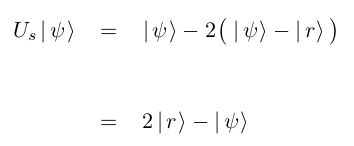

The second part of this operation should stand out to you, it’s just the Identity operator I. Thus, our unitary operator will have
the following form

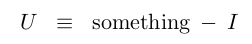

This something, is a operation that when applied to a state | ψ⟩, results in the state 2| r⟩. As mentioned before, | ri is a state
that is not guaranteed to be normalized, thus we cannot physically create it. However, the combination of 2 | r⟩ − | ψ⟩ will be
normalized.

The matrix operation that creates the state |r⟩ is as follows:

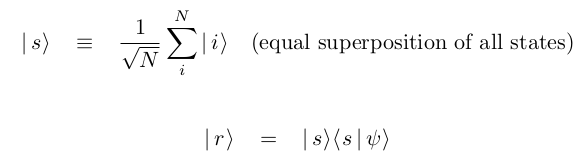

Thus, we can create | r⟩ by using the state | s⟩, which is definitely a physically realizable state (Hadamard gates on every qubit).
However, |s⟩⟨s| is not a unitary operator (if it were, it would mean that we could physically create | r⟩ ). Let’s quickly show
how these two quantities are equal:

1. The inner product ⟨s|ψ⟩ results in the following sum of all the amplitudes: $\frac{1}{\sqrt{N}}∑_{i}^{N}α_i$

2. We borrow the remaining $\frac{1}{\sqrt{N}}$ term from the other |s⟩ state, giving us our average amplitude: $\frac{1}{N}∑_{i}^{N}α_i = α_{avg} . $

3. This average amplitude $α_{avg}$ is left multiplying all of the states leftover from |s⟩, leaving us with:

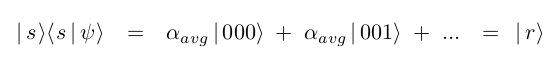

Thus, we now have a full mathematical description for $U_s$ :

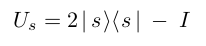

## **Implementing $U_s$ via $H^N$**
***

Although we just derived a nice compact form for our Grover Diffusion Operator, implementing it into our quantum algorithm is
a bit more challenging. As we pointed out, the operator as a whole is unitary, but the individual contributions are physically
unrealizable. But fear not, there is an impressively simple way of realizing $U_s$ , using a Hadamard Transformation (our favorite).

To start, we must take a slight detour from our algorithm in order to talk about a very important property of the Hadamard
Transformation, particularly how it transforms the state of all 0’s:

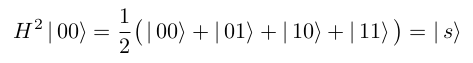

Nothing new here, but we want to take special note of how the Hadamard Transformation is a map between the state of all 0’s,
and the equal superposition state |s⟩:

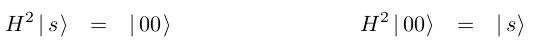

We just saw in our previous discussion that the state | s⟩ was exactly what we needed to create $U_s$ , and it’s no coincidence that
we are seeing it again here via the Hadamard Transformation. This $H^N$ mapping is what is going to allow us to implement the
Grover Diffusion Operator.

Although we’ve seen the Hadamard Transformation at the core of all our previous algorithms, this implementation is a bit
different. Previously, we used $H^ N$ as a way of simultaneously sampling all possible entries for our blackbox problems. Here,
we are using $H^ N$ in order to transform our system to a basis where the Grover Diffusion Operator is achievable in one simple
operation, and then transforming back. This use of $H^ N$ is identical to our use of X_Transformation, where we transform our
system to a different basis in order to use control gates.

Consider this somewhat silly example: Imagine you need to lift a 1 ton brick onto a shelf under Earth’s gravity, so you transform
your problem to the moon where gravity is weaker, do the lift, and then transform back to Earth. That’s the spirit of what we’re
going to achieve with this Hadamard Transformation here in the Grover Algorithm.

Before any further explanation, it’s more powerful to see it in action first:

In [37]:
q = QuantumRegister(2, name='q')
anc = QuantumRegister(1, name='anc')
n_anc = QuantumRegister(1, name='n_anc')
G_qc =  QuantumCircuit (q, anc, name='qc')

marked = [1,0]

G_qc.h( q[0])
G_qc.h( q[1])
G_qc.x( anc[0])

print('__ Initial State ___ ')
Wavefunction (G_qc, systems = [2,1], show_systems=[True, False])

Grover_Oracle (marked, G_qc, q, anc, n_anc) 

print("\n Grover Oracle: ",marked, " ___ ")
Wavefunction(G_qc, systems=[2,1], show_systems=[True, False])

G_qc.h( q[0])
G_qc.h( q[1])
Grover_Oracle([0,0], G_qc, q, anc, n_anc)
G_qc.h( q[0])
G_qc.h( q[1])

print("\n_ After Grover Diffusion __ ")
Wavefunction(G_qc, systems=[2,1], show_systems=[True, False])

__ Initial State ___ 
0.5 |00>     0.5 |10>     0.5 |01>     0.5 |11>     

 Grover Oracle:  [1, 0]  ___ 
0.5 |00>     -0.5 |10>     0.5 |01>     0.5 |11>     

_ After Grover Diffusion __ 
-1.0 |10>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


And viola! Like magic, we’ve increased the probability of our marked state, while suppressing all other states. And N = 2 (four
total states) is a special case, where all non-marked states get suppressed to amplitudes of 0! Feel free to change the marked
state in the example above, and see that the Grover Algorithm always makes our marked state dominant.

To see why this happened, let’s again draw the amplitudes before and after reflecting about the average:

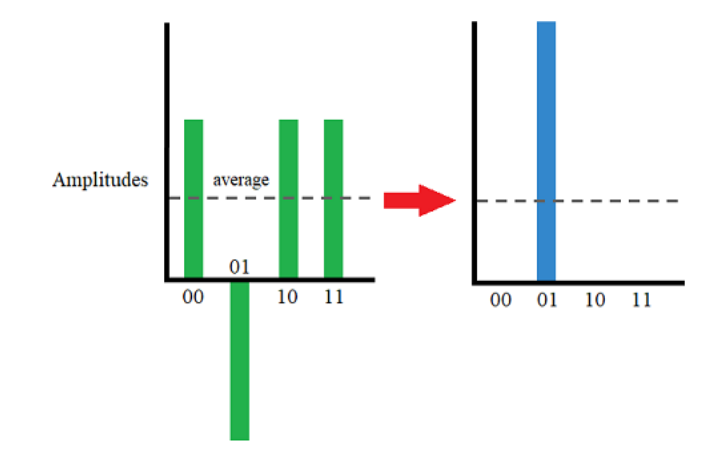

Because we flipped the sign on our marked state before $U_s$ (via the Oracle Operator), we effectively changed the average
amplitude. Then, because the average amplitude is positive and our marked state is negative, the reflection about this new
average results in a huge increase in amplitude. Simultaneously, all of our non-marked states have larger amplitudes than the
average, so the reflection causes their amplitudes to decrease.

Remember earlier that we took take special note of the transformation | 00...0⟩ ←→ $H^ N$ ←→ | s⟩. One way of thinking
about unitary transformations, is that operations performed in the two bases can look very different, but turn out to be equivalent.
Here, we avoid doing some complicated series of operations in our original basis by using a Hadamard Transformation to
achieve the same result with ease, and then transform back.

Let’s take a look at one more example:

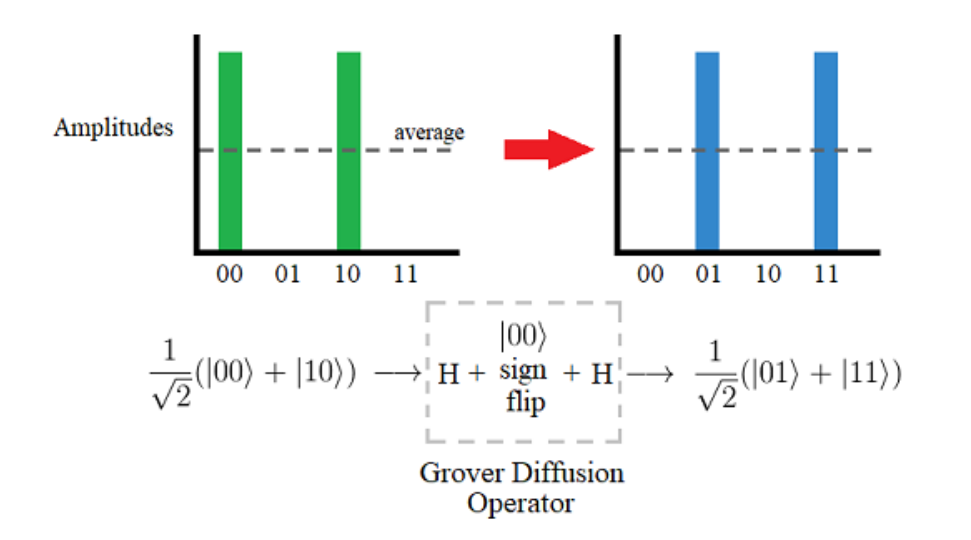

In particular, we pointed out that
the Hadamard transformation is a map between: | 00...0⟩ ←− H N −→ | s⟩. One way to understand this mapping is to say
that these states are equivalent, via the H N transformation. Thus, performing our reflection about |00...0⟩ in the transformed
basis is equivalent to a reflection about | si in our original basis. And, since flipping the sign on |00...0⟩ achieves a state parallel
to the reflection, transforming back via $H^N$ will also result in the parallel state to the reflection about the average, explaining
where our minus signs are coming from.

⭕ **Understanding how the mapping of | 00...0⟩ ←− H N −→ | s⟩ produces our reflection about the average is really the most important topic in this lesson, and will likely take a little time to fully sink in** 

## **The Full Grover Search**
***

In the coding examples above, we were able to fully pick out our marked state with only one application of our Grover Diffusion
Operator. Two qubits is a special case, and in general we will need many more applications in order to make our marked state
significantly probable. Specifically, we will need a certain number of Grover Iterations, based on the size of the problem. To
remind ourselves, a single Grover Iteration is defined as: 
1. Flipping the sign on our marked state via the Oracle Operator 
2. Applying the Grover Diffusion Operator.

The reason we will need many Grover Iterations as our problem size gets larger, is because each individual iteration will only
boost the probability of our marked state by so much. Consider the diagram below, which shows that a single Grover Iteration is
not enough to give our marked state a significant probability:

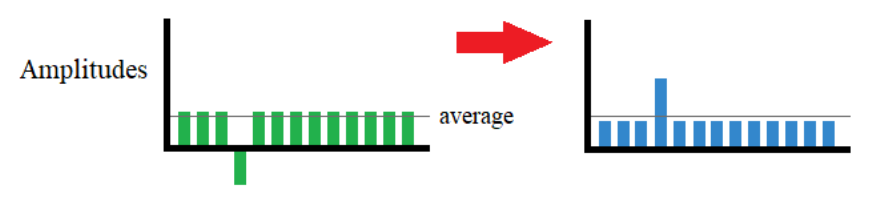



While one step does indeed make our marked state more probable, it isn’t significant enough to where it is worth making a
measurement. And as the size of our problem increases, this first step will be less and less impactful. However, we can simply
repeat the process as many times as we need to, until we reach a desirable probability distribution. For example, let’s apply one
more Grover Iteration to our diagram example:

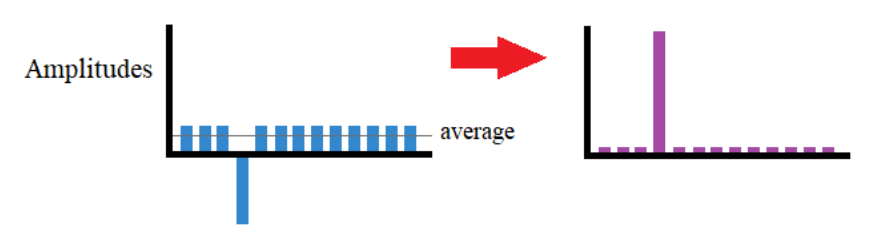

By applying a second Grover Iteration, we are essentially starting with a state where the amplitude of our marked state is already
larger than all the rest. This in turn causes the average amplitude to be smaller, which further decreases all the non-marked
states. Thus, after two Grover Iterations, we reach a state where a measurement on the system will find our marked state with a
high probability of success.

But, we must point out something very important here. The Grover Iteration is not a magical operation that always boosts the
amplitude of our marked state. The trick relies on the average amplitude, and at a certain point, the Grover Iteration actually
works against us. Let’s continue our diagram example with one more iteration to show this negative effect:

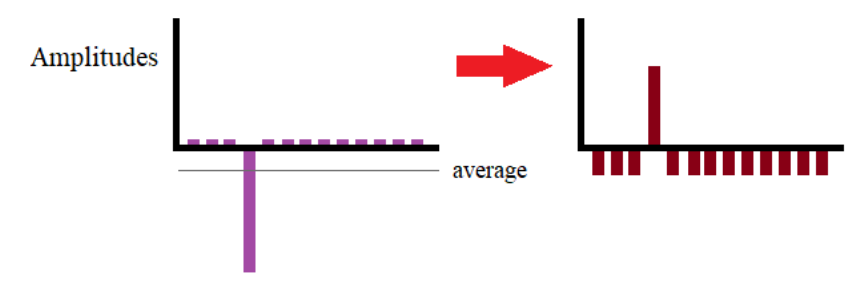

Take note of where the average amplitude is located in this third step. Because our marked state’s amplitude is so large, it
actually weighs the average down below 0 after we flip its sign. It is at this point where the Grover Iteration is working against
us. This negative average amplitude causes all of our non-marked states to increase in amplitude, which comes at the cost of
our marked state.

Even worse yet, try and visualize where the next average amplitude would be after we flip the marked state. Because all of
the non-marked states now have negative amplitudes, a fourth Grover Iteration will result in an even lower probability on our
marked state, eventually leading to a point where the marked state is the least probable state in the system.

Thus, this example has highlighted the final piece to the Grover Algorithm: when to stop. Too many Grover Iterations will make
things worse, so we need to never go over the optimal amount. Luckily for us, there is a well known trend that tells us when to
stop, for a system of N states:

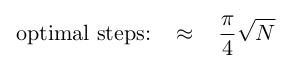

There is an ’exact optimal’ number of steps for any given N , which may not be exactly $\frac{π}{4} \sqrt{N} $ . But once N is large enough, applying $\frac{π}{4} \sqrt{N} $ Grover Internations will always be nearly optimal. The more problematic cases are for smaller N ’s, but these aren’t really too concerning since using a quantum algorithm for a search on a list of say 4 or 8 entries, is a bit of an overkill. **The real merit of this algorithm is for searching on very large lists, where the N factor is a significant speedup.** 

Now that we’ve seen the effect of too many Grover Iternations, let’s see it in a coding example. To do this, we will first implement
Grover Diffusion:

In [38]:
def Grover_Diffusion(mark, qc, q, an1, an2):
  '''
  Input:
  mark (array), qc (QuantumCircuit), q (QuantumRegister), an1 (QuantumRegister), an2 (QuantumRegister)
  Appends the neccessary gates for a Grover Diffusion operaton
  '''
  zeros_state = []
  for i in np.arange( len(mark) ):
    zeros_state.append( 0 )
    qc.h( q[int(i)] )
  Grover_Oracle(zeros_state, qc, q, an1, an2)
  for j in np.arange( len(mark) ):
    qc.h( q[int(j)] )

In [43]:
q = QuantumRegister(3,name="q")
anc  = QuantumRegister (1, name='anc') 
n_anc = QuantumRegister(1, name='n_anc')
G_qc =  QuantumCircuit (q, anc, n_anc, name='qc')

marked = [1,1,0]

G_qc.h( q[0])
G_qc.h( q[1])
G_qc.h( q[2])
G_qc.x( anc[0] )

print(" Initial State ")
Wavefunction (G_qc, systems=[3,1,1], show_systems=[True, False, False])

iterations = 3

for i in np.arange(iterations):
  Grover_Oracle (marked, G_qc, q, anc, n_anc) 
  Grover_Diffusion (marked, G_qc, q, anc, n_anc) 
  print("\n ", int(i+1), " __  Grover Iteration __  ") 
  Wavefunction(G_qc, systems=[3,1,1], show_systems=[True, False, False])

 Initial State 
0.35355 |000>     0.35355 |100>     0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     

  1  __  Grover Iteration __  
-0.17678 |000>     -0.17678 |100>     -0.17678 |010>     -0.88388 |110>     -0.17678 |001>     -0.17678 |101>     -0.17678 |011>     -0.17678 |111>     

  2  __  Grover Iteration __  
-0.08839 |000>     -0.08839 |100>     -0.08839 |010>     0.97227 |110>     -0.08839 |001>     -0.08839 |101>     -0.08839 |011>     -0.08839 |111>     

  3  __  Grover Iteration __  
0.30936 |000>     0.30936 |100>     0.30936 |010>     -0.57452 |110>     0.30936 |001>     0.30936 |101>     0.30936 |011>     0.30936 |111>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


Take a look at the amplitudes displayed above. After 1 Grover Iteration, we have a 78% percent chance of measuring our
marked state. After the second Grover Iteration, this probability jumps to over 94%! But, if we apply a third iteration, our
probability of measuring the marked state plummets to a measly 33% (but is still the highest single state). If we had carried out
a fourth iteration, we would find our marked state with a 1% probability, the complete opposite of what we set out to do!

This concludes our labs on introductory quantum algorithms! We saved this algorithm for last because of the way in which
we used $H^N$ , which is very analogous to the next lesson to come. In general, the use of unitary transformations are at the core
of a lot of the most successful quantum algorithms to date.